# Evaluation Tessa

In this notebook, we calculate the performance of Tessa on our datasets. Please run the script tessa_wraper for each dataset before running this notebook.

In [1]:
import os
import pandas as pd
import numpy as np

os.environ['R_HOME'] = 'C:/Users/felix.drost/Anaconda3/envs/tessa/Lib/R' 
import rpy2.robjects as rob

In [2]:
import sys
sys.path.append('..')
from tcr_embedding.evaluation.Metrics import get_knn_classification, get_normalized_mutual_information
from tcr_embedding.evaluation.Metrics import get_silhouette_scores

## Functions for Tessa embedding

In [3]:
def get_tessa_weights(base_dir):
    """
    Load the b-values from the result RData
    :param base_dir: path to the base folder of the experiment
    :return: numpy array [3] giving the b-weights
    """
    rob.r['load'](f'{base_dir}/res/tessa_final.RData')
    b = rob.r['tessa_results'][0]
    b = np.array(b)
    return b


def get_tessa_unweighted_distances(base_dir):
    """
    Extract the Briseis encoding from file
    :param base_dir: path to the base folder of the experiment
    :return: numpy array [num_cells, 30] giving the embedding space by Briseis
    """
    unweighted_dist = pd.read_csv(f'{base_dir}/tessa_tcr_embedding.csv', index_col=0)
    unweighted_dist = unweighted_dist.values
    return unweighted_dist


def get_weighted_distances(unweighted_dist, b):
    """
    Calculates the weigthed distance
    :param unweighted_dist: numpy array [num_cells, 30] giving the TCR embedding
    :param b: numpy array [30] giving the position weights
    :return: numpy array [num_cells, 30] giving the weighted embedding
    """
    weighted_dist = unweighted_dist * b
    return weighted_dist

def calculate_embedding(donor, do_atlas=True, do_weighting=True):
    suffix = 'atlas' 
    if not do_atlas:
        suffix = 'query'
    dir_out = f'tmp/{donor}/{suffix}'    
    embedding = get_tessa_unweighted_distances(dir_out)

    if do_weighting:
        b = get_tessa_weights(f'tmp/{donor}/atlas')
        embedding = get_weighted_distances(embedding, b)
    return embedding

## Calculate the Embeddings for different datasets

In [4]:
donor1_weighted = [calculate_embedding('donor_1', do_atlas=True, do_weighting=True),
                  calculate_embedding('donor_1', do_atlas=False, do_weighting=True)]
donor1_unweighted = [calculate_embedding('donor_1', do_atlas=True, do_weighting=False),
                  calculate_embedding('donor_1', do_atlas=False, do_weighting=False)]
donor2_weighted = [calculate_embedding('donor_2', do_atlas=True, do_weighting=True),
                  calculate_embedding('donor_2', do_atlas=False, do_weighting=True)]
donor2_unweighted = [calculate_embedding('donor_2', do_atlas=True, do_weighting=False),
                  calculate_embedding('donor_2', do_atlas=False, do_weighting=False)]

In [5]:
embedding_dict = {
    'donor_1_weighted': donor1_weighted,
    'donor_1_unweighted': donor1_unweighted,
    'donor_2_weighted': donor2_weighted,
    'donor_2_unweighted': donor2_unweighted,
}

## knn Evaluation

In [6]:
def get_labels(donor, return_df=False, col='binding_name'):
    """
    Extract the labels from the TCR file
    :param donor: id of the 10x donor
    :return: list [num_cells], list [num_cells] representing the binding labels for atlas and query set
    """
    path_labels = f'../data/tessa/10x/{donor}/'
    if donor == 'covid':
        path_labels = '../data/tessa/covid/all_donor/'
    df_atlas = pd.read_csv(path_labels+'tcrs_atlas.csv')
    df_query = pd.read_csv(path_labels+'tcrs_query.csv')
    if not return_df:
        return df_atlas[col].tolist(), df_query[col].tolist()
    df_atlas = df_atlas[['contig_id', col]]
    df_query = df_query[['contig_id', col]]
    
    df_atlas = df_atlas.set_index('contig_id')
    df_atlas.index.name = None
    df_query = df_query.set_index('contig_id')
    df_query.index.name = None
    return df_atlas, df_query

In [7]:
res_knn = {}
for setting, embeddings in embedding_dict.items():
    if 'covid' in setting:
        continue
    donor = '_'.join(setting.split('_')[0:-1])
    model = setting.split('_')[-1]
    labels_atlas, labels_query = get_labels(donor)
    results = get_knn_classification(embeddings[0], embeddings[1], labels_atlas, labels_query)
    if model not in res_knn.keys():
        res_knn[model] = {}
    res_knn[model][donor] = results['weighted avg']['f1-score']
    

In [8]:
pd.set_option("display.precision", 2)
df_knn = pd.DataFrame(res_knn)
df_knn

,weighted,unweighted
donor_1,0.55,0.59
donor_2,0.86,0.87


## Clustering Scores - NMI

In [9]:
def get_tessa_clusters(donor):
    rob.r['load'](f'tmp/{donor}/atlas/res/tessa_final.RData')
    clusters = rob.r['tessa_results'][1]
    df_clusters = pd.DataFrame(clusters)
    df_clusters = df_clusters.transpose()[[0, 2]]
    df_clusters[0] = [name.replace('.', '-') for name in df_clusters[0]]
    df_clusters = df_clusters.set_index(0)
    df_clusters.index.name = None
    df_clusters.columns = ['cluster']
    return df_clusters

In [10]:
res_cluster = {}
for setting, embeddings in embedding_dict.items():
    donor = '_'.join(setting.split('_')[0:-1])
    model = setting.split('_')[-1]
    if model == 'unweighted':
        continue
    labels_atlas, _ = get_labels(donor, return_df=True)
    labels_predicted = get_tessa_clusters(donor)
    df_full = pd.concat([labels_atlas, labels_predicted], axis=1)
    results = get_normalized_mutual_information(df_full['binding_name'], df_full['cluster'])
    if 'NMI' not in res_cluster.keys():
        res_cluster['NMI'] = {}
    res_cluster['NMI'][donor] = results

## Cluster Scores - Silhoutte

In [11]:
for setting, embeddings in embedding_dict.items():
    donor = '_'.join(setting.split('_')[0:-1])
    model = setting.split('_')[-1]
    if model == 'unweighted':
        continue
    
    labels_predicted = get_tessa_clusters(donor)
    results = get_silhouette_scores(embeddings[0], labels_predicted['cluster'])
    if 'AWS' not in res_cluster.keys():
        res_cluster['AWS'] = {}
    res_cluster['AWS'][donor] = results

In [12]:
pd.set_option("display.precision", 2)
df_cluster = pd.DataFrame(res_cluster)
print('Tessa clustering scores')
df_cluster

Tessa clustering scores


,NMI,AWS
donor_1,0.48,0.71
donor_2,0.41,0.76


## UMAP

In [13]:
import scanpy as sc
import anndata as ad
from tcr_embedding.constants import ANTIGEN_COLORS
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)

... storing 'binding' as categorical


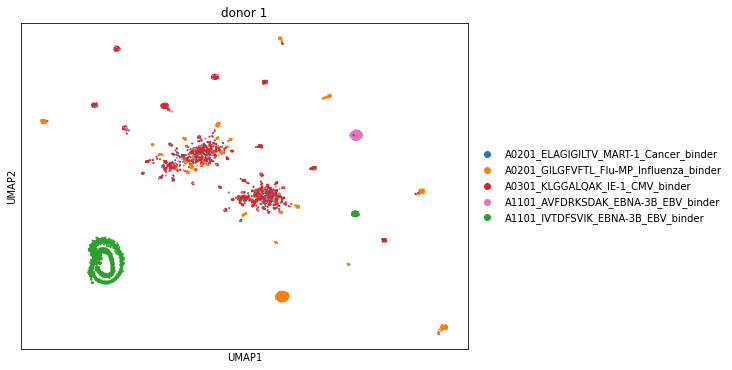

... storing 'binding' as categorical


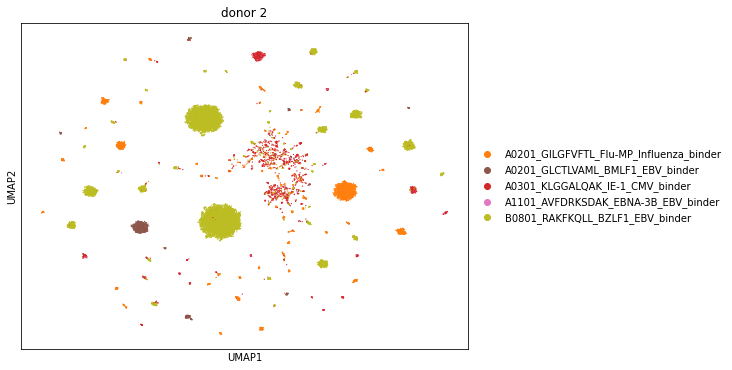

In [14]:
for i in range(1, 3):
    labels, _ = get_labels(f'donor_{i}')
    adata = ad.AnnData(embedding_dict[f'donor_{i}_weighted'][0], obs={'binding': labels})
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='binding', palette=ANTIGEN_COLORS, title=f'donor {i}')

## Covid Dataset

In [15]:
def get_labels_covid(return_df=False, col='binding_name'):
    path_labels = '../data/tessa/covid/all_donor/'
    df_atlas = pd.read_csv(path_labels+'tcrs_atlas.csv')
    if not return_df:
        return df_atlas[col].tolist()
    df_atlas = df_atlas[['contig_id', col]]
    
    df_atlas = df_atlas.set_index('contig_id')
    df_atlas.index.name = None
    return df_atlas

In [16]:
covid_weighted = [calculate_embedding('all_donor', do_atlas=True, do_weighting=True)]

In [17]:
donor = 'all_donor'

for col in ['T_cells', 'reactivity']:
    labels_atlas = get_labels_covid(return_df=True, col=col)
    labels_predicted = get_tessa_clusters(donor)

    df_full = pd.concat([labels_atlas, labels_predicted], axis=1)
    results = get_normalized_mutual_information(df_full[col], df_full['cluster'])
    
    if col == 'T_cells':    
        col = 'TC'
    else:
        col = 'RT'
        
    if 'NMI-' + col not in res_cluster.keys():
        res_cluster['NMI-'+col] = {}
    res_cluster['NMI-'+col]['covid'] = results

In [18]:
pd.set_option("display.precision", 2)
df_cluster = pd.DataFrame(res_cluster)
print('Tessa clustering scores')
df_cluster

Tessa clustering scores


,NMI,AWS,NMI-TC,NMI-RT
donor_1,0.48,0.71,NaN,NaN
donor_2,0.41,0.76,NaN,NaN
covid,NaN,NaN,0.13,0.09


In [19]:
from sklearn.metrics import silhouette_score
donor = 'all_donor'

labels_predicted = get_tessa_clusters(donor)

results = silhouette_score(covid_weighted[0], labels_predicted['cluster'], metric='euclidean', random_state=29031995)

if 'AWS' not in res_cluster.keys():
    res_cluster['AWS'] = {}
res_cluster['AWS']['covid'] = results

In [20]:
pd.set_option("display.precision", 2)
df_cluster = pd.DataFrame(res_cluster)
print('Tessa clustering scores')
df_cluster

Tessa clustering scores


,NMI,AWS,NMI-TC,NMI-RT
donor_1,0.48,0.71,NaN,NaN
donor_2,0.41,0.76,NaN,NaN
covid,NaN,0.19,0.13,0.09


In [21]:
labels_tc = get_labels_covid(col='T_cells', return_df=True)
labels_rt = get_labels_covid(col='reactivity', return_df=True)
labels_tessa = get_tessa_clusters('all_donor')
df_full = pd.concat([labels_tc, labels_rt, labels_tessa], axis=1)
df_full

,T_cells,reactivity,cluster
Sample_20063a009_01_AAACCTGGTAAACGCG,Cd4 (PBMC),un-reactive,ASSFSGGPYEQY
Sample_20063a009_01_AAACCTGGTAACGCGA,Cd8 (PBMC),un-reactive,ASSVDTYEQY
Sample_20063a009_01_AAACCTGGTAATAGCA,Cd4 (PBMC),un-reactive,ASSVEGSYNEQF
Sample_20063a009_01_AAACCTGGTCAGAGGT,Cd8 (PBMC),un-reactive,ASSESGQGNTEAF
Sample_20063a009_01_AAACCTGGTGTATGGG,Cd8 (PBMC),un-reactive,ASDDRTNTGELF
...,...,...,...
Sample_20063a010_01_TTTGTCAGTCTAAACC,Cd4 (PBMC),un-reactive,ASSGGRQETFYEQY
Sample_20063a010_01_TTTGTCAGTTGCGCAC,Cd4 (PBMC),un-reactive,ASSGGGLGEETQY
Sample_20063a010_01_TTTGTCATCAAACCGT,Cd4 (PBMC),un-reactive,ASSLSGTRTYEQY
Sample_20063a010_01_TTTGTCATCATGGTCA,Cd4 (PBMC),un-reactive,ASSPRTVQETQY


In [22]:
labels_tc = get_labels_covid(col='T_cells', return_df=True)['T_cells']
labels_rt = get_labels_covid(col='reactivity', return_df=True)['reactivity']
labels_tessa = get_tessa_clusters('all_donor')['cluster']
df_labels = pd.concat([labels_tc, labels_rt, labels_tessa], axis=1)

idx = pd.read_csv('tmp/all_donor/atlas/tessa_tcr_embedding.csv')['contig_id']
df_x = pd.DataFrame(data=covid_weighted[0], index=idx)

adata = ad.AnnData(df_x)
adata.obs['cell type'] = labels_tc
adata.obs['reactivity'] = labels_rt
adata.obs['tessa'] = labels_tessa

In [23]:
adata.obs['reactivity'].unique()

array(['un-reactive', 'CD4 reactive', 'CD8 reactive'], dtype=object)

In [24]:
np.random.seed(42)
reactive_states = ['CD4 reactive', 'CD8 reactive']
adata_reactive = adata[adata.obs['reactivity'].isin(reactive_states)]
adata_unreactive = adata[~adata.obs['reactivity'].isin(reactive_states)]
p = len(adata_reactive)/len(adata_unreactive)
downsample_mask =  np.random.choice([True, False], size=len(adata_unreactive), replace=True, p=[p, 1-p])
adata_unreactive = adata_unreactive[downsample_mask]
adata_subsample = adata_reactive.concatenate([adata_unreactive])
adata = adata_subsample

... storing 'cell type' as categorical
... storing 'reactivity' as categorical
... storing 'tessa' as categorical


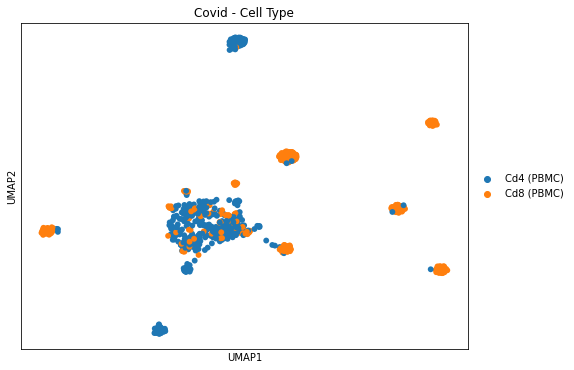

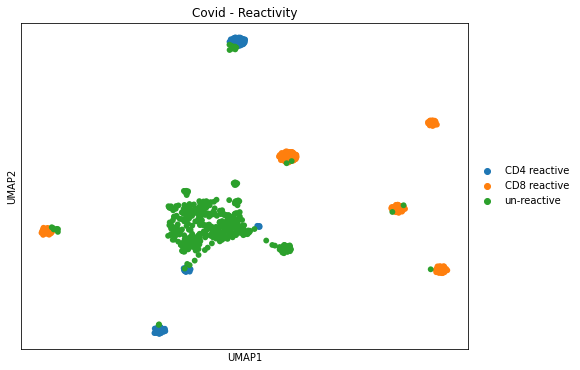

In [25]:

sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell type', title=f'Covid - Cell Type')
sc.pl.umap(adata, color='reactivity', title=f'Covid - Reactivity')